In [32]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from tensorflow import set_random_seed
from numpy.random import seed
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [4]:
set_random_seed(1)
seed(1)

In [5]:
#Convert the train data into time series
def time_series_data(data, window, lag):
    dropnan = True
    cols, names = list(), list()

    for i in range(window, 0, -1):
        #past time series data (t-)
        cols.append(data.shift(i))
        names = names + [('%s(t-%d)' % (col, i)) for col in data.columns]
    
    #current time series data (t = 0)
    cols.append(data)
    names = names + [('%s(t)' % (col)) for col in data.columns]
    
    #future data (t + lag)
    cols.append(data.shift(-lag))
    names = names + [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    #all data
    all_data = pd.concat(cols, axis=1)
    all_data.columns = names
    
    #drops rows with NaN
    if dropnan:
        all_data.dropna(inplace=True)
    return all_data

In [39]:
dataset = pd.read_csv('sales data-set.csv', usecols = ['Store', 'Item', 'Date', 'Weekly_Sales'])
train = dataset[['Store', 'Item', 'Date', 'Weekly_Sales']]
train = train.loc[(train['Store'] == 1) & (train['Item'] == 1)]
print(train.head())

       Store  Item        Date  Weekly_Sales
0          1     1  2010-02-07      24924.50
2955       1     1  2010-02-14      46039.49
5911       1     1  2010-02-21      41595.55
8888       1     1  2010-02-28      19403.54
11839      1     1  2010-03-07      21827.90


In [40]:
#Re-arranges the train dataset to apply shift methods
train_r = train.sort_values('Date').groupby(['Item', 'Store', 'Date'], as_index=False)
train_r = train_r.agg({'Weekly_Sales':['mean']})
train_r.columns = ['Item', 'Store', 'Date', 'Weekly_Sales']
#weekly sales in 10 thousand dollars
train_r['Weekly_Sales'] = train_r['Weekly_Sales'] / 10000
train_r.head()

,Item,Store,Date,Weekly_Sales
0,1,1,2010-02-07,2.492450
1,1,1,2010-02-14,4.603949
2,1,1,2010-02-21,4.159555
3,1,1,2010-02-28,1.940354
4,1,1,2010-03-07,2.182790


In [41]:
#the model will use last 117 weekly sales data and 
#current timestep (7 days) to forecast next weekly sales data 12 weeks ahead

window = 117
lag = 12

series_data = time_series_data(train_r, window, lag)
series_data.head()

,Item(t-117),Store(t-117),Date(t-117),Weekly_Sales(t-117),Item(t-116),Store(t-116),Date(t-116),Weekly_Sales(t-116),Item(t-115),Store(t-115),...,Date(t-1),Weekly_Sales(t-1),Item(t),Store(t),Date(t),Weekly_Sales(t),Item(t+12),Store(t+12),Date(t+12),Weekly_Sales(t+12)
117,1.0,1.0,2010-02-07,2.492450,1.0,1.0,2010-02-14,4.603949,1.0,1.0,...,2012-04-29,1.634760,1,1,2012-05-06,1.714744,1.0,1.0,2012-07-29,1.573118
118,1.0,1.0,2010-02-14,4.603949,1.0,1.0,2010-02-21,4.159555,1.0,1.0,...,2012-05-06,1.714744,1,1,2012-05-13,1.816420,1.0,1.0,2012-08-05,1.662831
119,1.0,1.0,2010-02-21,4.159555,1.0,1.0,2010-02-28,1.940354,1.0,1.0,...,2012-05-13,1.816420,1,1,2012-05-20,1.851779,1.0,1.0,2012-08-12,1.611992
120,1.0,1.0,2010-02-28,1.940354,1.0,1.0,2010-03-07,2.182790,1.0,1.0,...,2012-05-20,1.851779,1,1,2012-05-27,1.696355,1.0,1.0,2012-08-19,1.733070
121,1.0,1.0,2010-03-07,2.182790,1.0,1.0,2010-03-14,2.104339,1.0,1.0,...,2012-05-27,1.696355,1,1,2012-06-03,1.606549,1.0,1.0,2012-08-26,1.628640


In [42]:
#drops last record of (t + lag)
last_record_item = 'Item(t-%d)' % window
last_record_store = 'Store(t-%d)' % window
series_data = series_data[(series_data['Item(t)'] == series_data[last_record_item])]
series_data = series_data[(series_data['Store(t)'] == series_data[last_record_store])]

#drops Item and Store columns
cols_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['Item', 'Store', 'Date']]
for i in range(window, 0, -1):
    cols_to_drop += [('%s(t-%d)' % (col, i)) for col in ['Item', 'Store', 'Date']]

series_data.drop(cols_to_drop, axis=1, inplace=True)
series_data.drop(['Item(t)', 'Store(t)', 'Date(t)'], axis=1, inplace=True)

lbls_col = 'Weekly_Sales(t+%d)' % lag
lbls = series_data[lbls_col]
series_data = series_data.drop(lbls_col, axis=1)

series_data.head()

,Weekly_Sales(t-117),Weekly_Sales(t-116),Weekly_Sales(t-115),Weekly_Sales(t-114),Weekly_Sales(t-113),Weekly_Sales(t-112),Weekly_Sales(t-111),Weekly_Sales(t-110),Weekly_Sales(t-109),Weekly_Sales(t-108),...,Weekly_Sales(t-9),Weekly_Sales(t-8),Weekly_Sales(t-7),Weekly_Sales(t-6),Weekly_Sales(t-5),Weekly_Sales(t-4),Weekly_Sales(t-3),Weekly_Sales(t-2),Weekly_Sales(t-1),Weekly_Sales(t)
117,2.492450,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,...,2.011303,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744
118,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,...,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420
119,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,...,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779
120,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,...,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355
121,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,...,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549


In [43]:
#train and test split

X_train, X_test, Y_train, Y_test = train_test_split(series_data, lbls.values, test_size=0.3, random_state=0)

print('Train dataset:', X_train.shape)
print('Test dataset:', X_test.shape)
X_train.head()

Train dataset: (9, 118)
Test dataset: (5, 118)


,Weekly_Sales(t-117),Weekly_Sales(t-116),Weekly_Sales(t-115),Weekly_Sales(t-114),Weekly_Sales(t-113),Weekly_Sales(t-112),Weekly_Sales(t-111),Weekly_Sales(t-110),Weekly_Sales(t-109),Weekly_Sales(t-108),...,Weekly_Sales(t-9),Weekly_Sales(t-8),Weekly_Sales(t-7),Weekly_Sales(t-6),Weekly_Sales(t-5),Weekly_Sales(t-4),Weekly_Sales(t-3),Weekly_Sales(t-2),Weekly_Sales(t-1),Weekly_Sales(t)
130,1.741394,1.892674,1.477304,1.558043,1.755809,1.663762,1.621627,1.632872,1.633314,1.768876,...,1.606549,1.766600,1.755882,1.663341,1.572282,1.782337,1.656618,1.634806,1.573118,1.662831
126,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,1.558043,1.755809,1.663762,...,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882,1.663341,1.572282,1.782337
118,4.603949,4.159555,1.940354,2.182790,2.104339,2.213664,2.622921,5.725843,4.296091,1.759696,...,2.114007,2.236688,2.210770,2.895286,5.759212,3.468421,1.697619,1.634760,1.714744,1.816420
124,2.622921,5.725843,4.296091,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,1.558043,...,1.697619,1.634760,1.714744,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882,1.663341
127,1.759696,1.614535,1.655511,1.741394,1.892674,1.477304,1.558043,1.755809,1.663762,1.621627,...,1.816420,1.851779,1.696355,1.606549,1.766600,1.755882,1.663341,1.572282,1.782337,1.656618


In [44]:
epochs = 50
#batch = 32
learning_rate = 0.0003
adam = optimizers.Adam(learning_rate)

### MLP

In [45]:
#MLP
model_mlp = Sequential()
model_mlp.add(Dense(50, activation = 'relu', input_dim = X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss = 'mse', optimizer=adam)
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 50)                5950      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


In [46]:
mlp = model_mlp.fit(X_train.values, Y_train, validation_data = (X_test.values, Y_test), epochs = epochs, verbose = 1)

Train on 9 samples, validate on 5 samples
Epoch 1/50
9/9 [==============================] - 2s 178ms/step - loss: 13.4696 - val_loss: 12.0023
Epoch 2/50
9/9 [==============================] - 0s 445us/step - loss: 11.5982 - val_loss: 9.8688
Epoch 3/50
9/9 [==============================] - 0s 556us/step - loss: 9.6653 - val_loss: 7.9239
Epoch 4/50
9/9 [==============================] - 0s 445us/step - loss: 7.8898 - val_loss: 6.1996
Epoch 5/50
9/9 [==============================] - 0s 333us/step - loss: 6.3114 - val_loss: 4.7436
Epoch 6/50
9/9 [==============================] - 0s 667us/step - loss: 4.9867 - val_loss: 3.5572
Epoch 7/50
9/9 [==============================] - 0s 443us/step - loss: 3.9176 - val_loss: 2.6202
Epoch 8/50
9/9 [==============================] - 0s 441us/step - loss: 3.0805 - val_loss: 1.9141
Epoch 9/50
9/9 [==============================] - 0s 445us/step - loss: 2.4644 - val_loss: 1.4096
Epoch 10/50
9/9 [==============================] - 0s 444us/step - loss: 

### CNN

In [47]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train dataset:', X_train_series.shape)
print('Test dataset:', X_test_series.shape)

Train dataset: (9, 118, 1)
Test dataset: (5, 118, 1)


In [48]:
#CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', input_shape = (X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size = 2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss = 'mse', optimizer = adam)
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 117, 64)           192       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 58, 64)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                185650    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 185,893
Trainable params: 185,893
Non-trainable params: 0
_________________________________________________________________


In [49]:
cnn = model_cnn.fit(X_train_series, Y_train, validation_data = (X_test_series, Y_test), epochs = epochs, verbose = 1)

Train on 9 samples, validate on 5 samples
Epoch 1/50
9/9 [==============================] - 2s 198ms/step - loss: 3.5364 - val_loss: 1.3607
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 1.7007 - val_loss: 0.1425
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2736 - val_loss: 0.5918
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.4220 - val_loss: 1.6167
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 1.2436 - val_loss: 1.5920
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 1.2212 - val_loss: 0.9190
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6639 - val_loss: 0.3129
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2093 - val_loss: 0.0925
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 0.0940 - val_loss: 0.0917
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1752 - val_loss: 0.

### LSTM

In [50]:
#LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation = 'relu', input_shape = (X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss = 'mse', optimizer = adam)
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [51]:
lstm = model_lstm.fit(X_train_series, Y_train, validation_data = (X_test_series, Y_test), epochs = epochs, verbose = 1)

Train on 9 samples, validate on 5 samples
Epoch 1/50
9/9 [==============================] - 3s 329ms/step - loss: 5.1978 - val_loss: 4.4830
Epoch 2/50
9/9 [==============================] - 0s 20ms/step - loss: 5.1246 - val_loss: 4.3930
Epoch 3/50
9/9 [==============================] - 0s 24ms/step - loss: 5.0288 - val_loss: 4.2913
Epoch 4/50
9/9 [==============================] - 0s 32ms/step - loss: 4.9202 - val_loss: 4.1836
Epoch 5/50
9/9 [==============================] - 0s 30ms/step - loss: 4.8050 - val_loss: 4.0736
Epoch 6/50
9/9 [==============================] - 0s 35ms/step - loss: 4.6870 - val_loss: 3.9631
Epoch 7/50
9/9 [==============================] - 0s 32ms/step - loss: 4.5678 - val_loss: 3.8527
Epoch 8/50
9/9 [==============================] - 0s 31ms/step - loss: 4.4494 - val_loss: 3.7424
Epoch 9/50
9/9 [==============================] - 0s 28ms/step - loss: 4.3310 - val_loss: 3.6321
Epoch 10/50
9/9 [==============================] - 0s 32ms/step - loss: 4.2129 - val

### CNN-LSTM

In [52]:
#CNN-LSTM
subsequences = 2
time_steps = X_train_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, time_steps, 1))
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, time_steps, 1))
print('Train dataset:', X_train_series_sub.shape)
print('Test dataset:', X_test_series_sub.shape)

Train dataset: (9, 2, 59, 1)
Test dataset: (5, 2, 59, 1)


In [75]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 1, activation = 'relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation = 'relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss = 'mse', optimizer = 'adam')
model_cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, None, 59, 64)      128       
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 29, 64)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 1856)        0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                381400    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 381,579
Trainable params: 381,579
Non-trainable params: 0
_________________________________________________________________


In [76]:
cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data = (X_test_series_sub, Y_test), epochs = epochs, verbose = 1)

Train on 9 samples, validate on 5 samples
Epoch 1/50
9/9 [==============================] - 4s 435ms/step - loss: 3.7103 - val_loss: 0.7420
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 1.0051 - val_loss: 0.3653
Epoch 3/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3805 - val_loss: 1.0216
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 0.9836 - val_loss: 0.3327
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3257 - val_loss: 0.0624
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1276 - val_loss: 0.1853
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 0.3139 - val_loss: 0.2954
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 0.4507 - val_loss: 0.2755
Epoch 9/50
9/9 [==============================] - 0s 6ms/step - loss: 0.4225 - val_loss: 0.1631
Epoch 10/50
9/9 [==============================] - 0s 6ms/step - loss: 0.2744 - val_loss: 0.

### Comparison of ANN Models 

              Performances of different ANN models for time series dataset


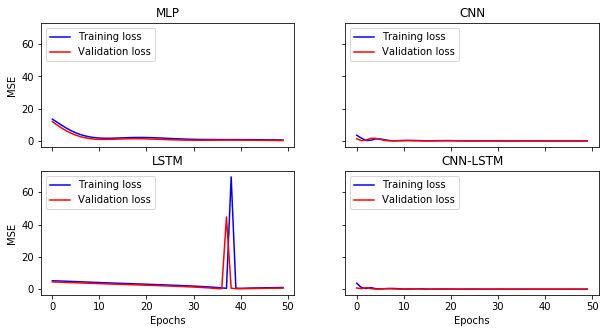

<Figure size 432x288 with 0 Axes>

In [90]:
#comparing models
print("              Performances of different ANN models for time series dataset")
fig, axes = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 5))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp.history['loss'], label = 'Training loss', color = 'blue')
ax1.plot(mlp.history['val_loss'], label = 'Validation loss', color = 'red')
ax1.legend(loc = 'upper left')
ax1.set_title('MLP')
ax1.set_ylabel('MSE')

ax2.plot(cnn.history['loss'], label = 'Training loss', color = 'blue')
ax2.plot(cnn.history['val_loss'], label = 'Validation loss', color = 'red')
ax2.legend(loc = 'upper left')
ax2.set_title('CNN')
ax3.plot(lstm.history['loss'], label= 'Training loss', color = 'blue')
ax3.plot(lstm.history['val_loss'], label = 'Validation loss', color = 'red')
ax3.legend(loc = 'upper left')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm.history['loss'], label = 'Training loss', color = 'blue')
ax4.plot(cnn_lstm.history['val_loss'], label = 'Validation loss', color = 'red')
ax4.legend(loc = 'upper left')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')

plt.show()
#plt.savefig('images\model_comparison.png', bbox_inches='tight')